# Rossmann Store Sales Prediction

![](https://i.imgur.com/6MYc56a.png)

## Problem Statement

This is a real-world dataset taken from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

### Data fields
Let us look at the more information about the features from the dataset

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [1]:
!pip install opendatasets --quiet

In [2]:
import os
import opendatasets as od
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error


pd.set_option('display.max_columns', None)

In [3]:
data_dir = './Kaggle/Rossmann store sale/'

In [4]:
# Let us download the dataset from the Kaggle
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikhilpatil44
Your Kaggle Key: ········


100%|██████████████████████████████████████████████████████████████████████████████| 6.99M/6.99M [00:35<00:00, 208kB/s]



Extracting archive .\rossmann-store-sales/rossmann-store-sales.zip to .\rossmann-store-sales


In [5]:
# Let us check the files present in the Rossmann Store Sale folder
os.listdir('/Kaggle/Rossmann store sale/Rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

In [6]:
ross_df = pd.read_csv('./Rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./Rossmann-store-sales/store.csv')
test_df = pd.read_csv('./Rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./Rossmann-store-sales/sample_submission.csv')

In [7]:
# Now we will look at the train data
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [8]:
# We will also look at the store data
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Store data contains 1115 rows & 10 columns. From this data, we can see that there are total 1115 stores. The store dataset given information about different store types, when compition was started, distance of nearest competitor store, whether a store is running a promo on that day, approximate year and month of the time the nearest competitor was opened etc. This dataset seems to have some of the information was missing.


In [9]:
# Let us look at the test dataset
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [10]:
# Now we will combine the store data & train data
merged_train_df = ross_df.merge(store_df, how='left', on='Store')
# We will also combine test data & store data
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [11]:
merged_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [12]:
# Print the merged test data
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Data Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [13]:
# Now we will check the more information about the merged_train_df 
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

We can see that the dataset seems to have some of the information missing in some features.


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [14]:
# Let us define a function to convert the date to datecolumn & extract different parts of the date for getting more information.
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [15]:
# Now we will use that function to extract the date information from the merged_train_df
split_date(merged_train_df)
# Also we will apply that function to extract the date information from the merged_test_df
split_date(merged_test_df)

In [16]:
# Let us print the merged_train_df to see the extracted date features
merged_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


In [17]:
# We will see the merged_test_df to check the splitted date features
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17,38
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2015,8,1,31
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31


### Store Open/Closed

From the dataset, we have notice that the sales are zero whenever the store is closed.

In [18]:
merged_train_df[merged_train_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and so remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [19]:
merged_train_df = merged_train_df[merged_train_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [20]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [21]:
comp_months(merged_train_df)
comp_months(merged_test_df)

In [22]:
merged_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


In [23]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38,84.0
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,105.0
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38,29.0
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17,38,11.0
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17,38,181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31,14.0
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2015,8,1,31,112.0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31,0.0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31,0.0


Let's view the results of the new columns we've created.

In [24]:
merged_train_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(10)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
594028,2014-01-15,2510.0,2009.0,8.0,53.0
741237,2013-09-05,3760.0,2009.0,2.0,55.0
134640,2015-04-02,27650.0,2004.0,8.0,128.0
111615,2015-04-22,680.0,2013.0,4.0,24.0
670232,2013-11-08,7290.0,2014.0,9.0,0.0
385488,2014-07-25,12920.0,2012.0,9.0,22.0
281228,2014-11-14,3750.0,2001.0,11.0,156.0
929093,2013-03-21,190.0,NaN,NaN,0.0
199592,2015-02-02,7520.0,2014.0,10.0,4.0
594852,2014-01-14,10800.0,NaN,NaN,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [25]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [26]:
promo_cols(merged_train_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [27]:
merged_train_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(10)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
94068,2015-05-08,1,2013.0,1.0,"Jan,Apr,Jul,Oct",28.131148,0
177099,2015-02-23,0,NaN,NaN,NaN,0.000000,0
707985,2013-10-05,1,2011.0,35.0,"Mar,Jun,Sept,Dec",25.147541,0
364578,2014-08-16,0,NaN,NaN,NaN,0.000000,0
145797,2015-03-23,1,2011.0,14.0,"Jan,Apr,Jul,Oct",47.770492,0
962135,2013-02-19,0,NaN,NaN,NaN,0.000000,0
669867,2013-11-08,0,NaN,NaN,NaN,0.000000,0
126123,2015-04-09,1,2011.0,14.0,"Jan,Apr,Jul,Oct",48.229508,1
97427,2015-05-05,0,NaN,NaN,NaN,0.000000,0
11231,2015-07-21,1,2009.0,37.0,"Jan,Apr,Jul,Oct",70.393443,1


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [28]:
merged_train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [29]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [30]:
inputs = merged_train_df[input_cols].copy()
targets = merged_train_df[target_col].copy()

In [31]:
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.000000,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.000000,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,1.213115,1
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.000000,0


In [32]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

In [33]:
test_inputs = merged_test_df[input_cols].copy()

In [34]:
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.000000,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,53.508197,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.000000,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.000000,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.000000,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.000000,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.000000,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.000000,0


Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [35]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear' ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [36]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [37]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [38]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [39]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [42]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [43]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [44]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [45]:
inputs[encoded_cols]

,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Finally, let's extract out all the numeric data for training.

In [46]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

### Model Training



### XGBOOST
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. Please see the chart below for the evolution of tree-based algorithms over the years.

![](https://miro.medium.com/max/1400/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg)

![](https://miro.medium.com/max/1400/1*FLshv-wVDfu-i54OqvZdHg.png)



In [47]:
xgb_model = XGBRegressor(random_state=42, n_jobs= -1, n_estimators= 20, max_depth=4)

In [48]:
%%time
xgb_model.fit(X, targets)

Wall time: 12.1 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
preds = xgb_model.predict(X)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [50]:
from sklearn.metrics import mean_squared_error
# Let us define a function to get rmse score
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [51]:
rmse(preds, targets)

2377.752008804669

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [52]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 35,25

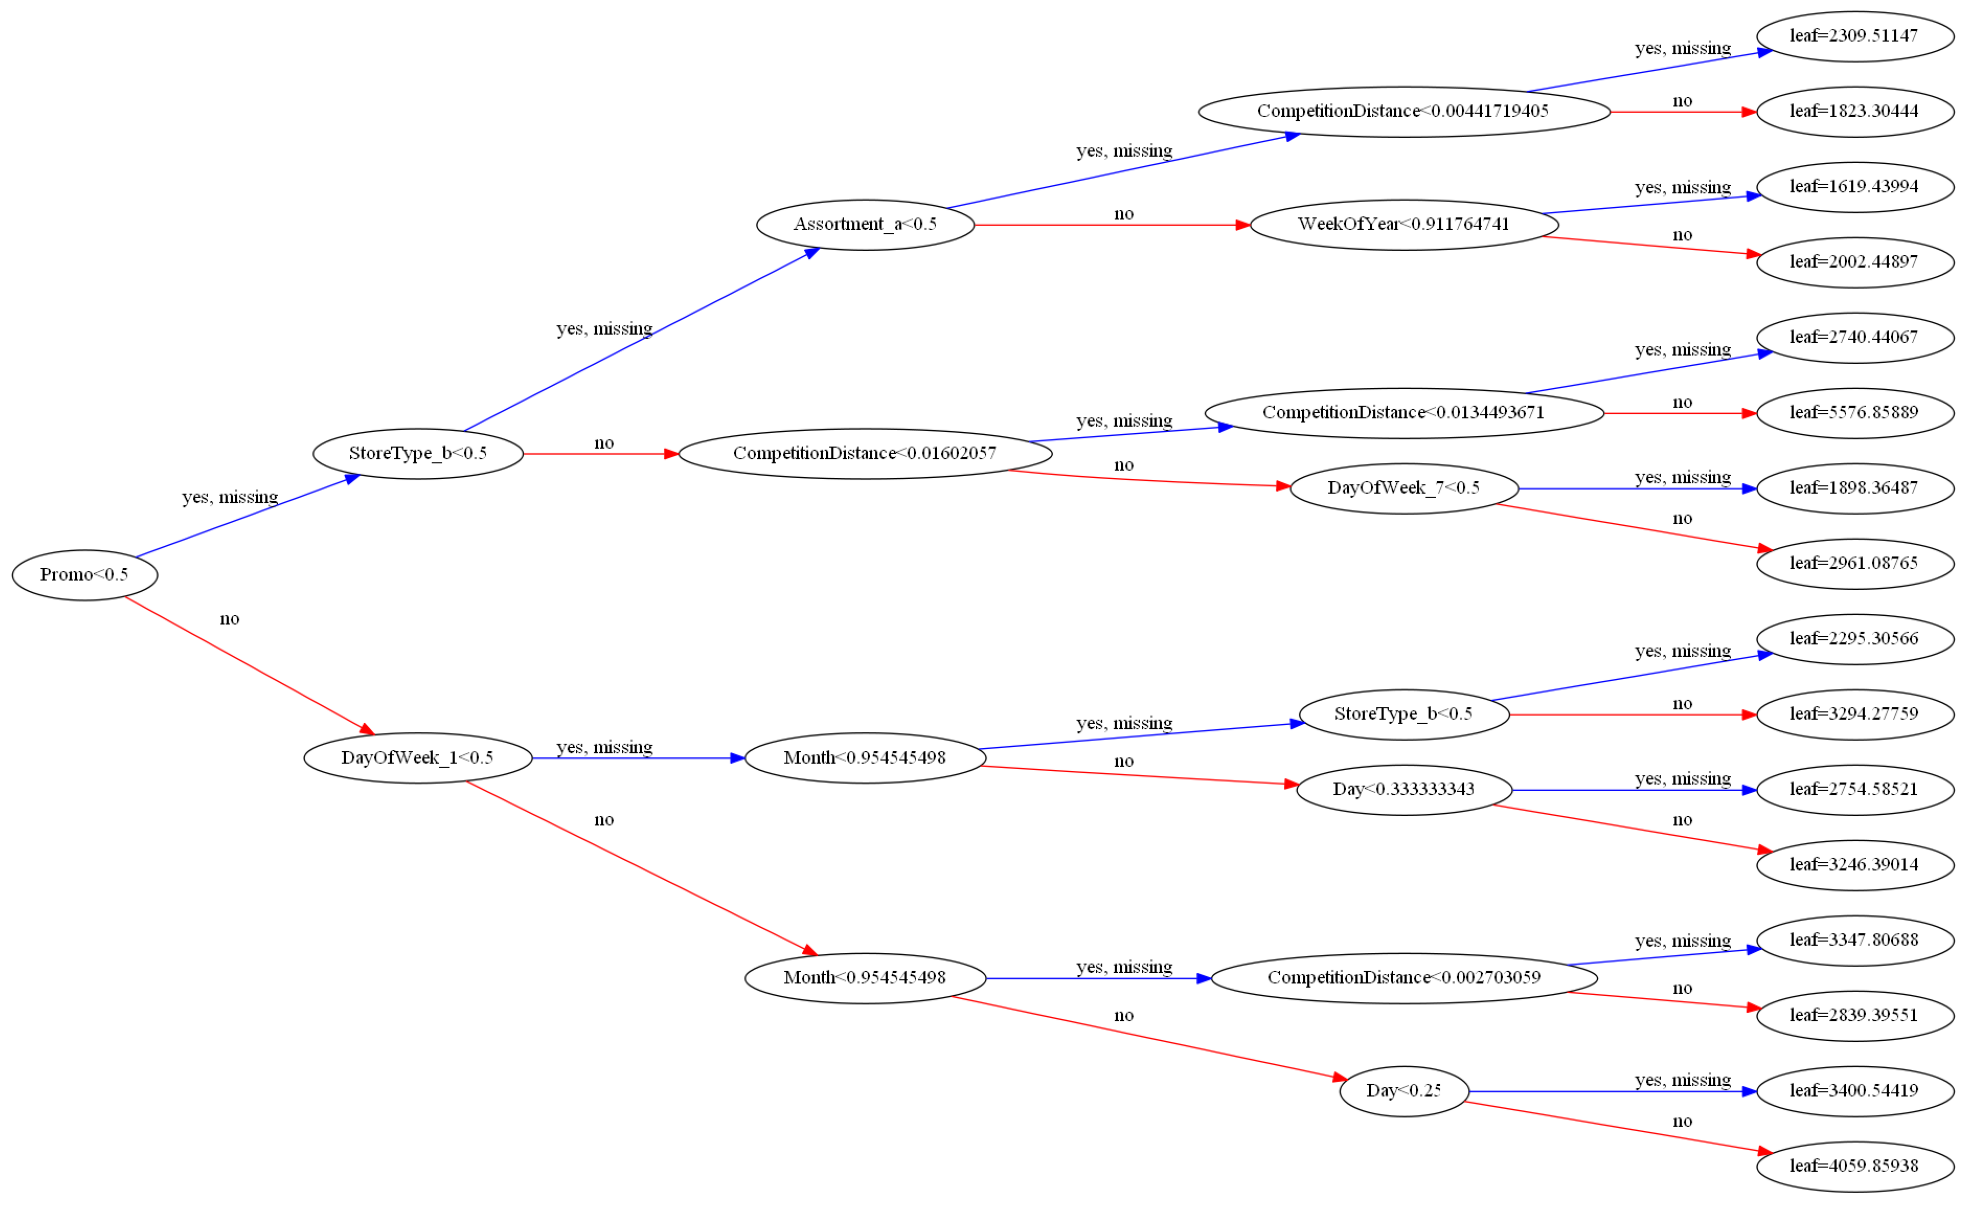

In [53]:
plot_tree(xgb_model, rankdir= 'LR');

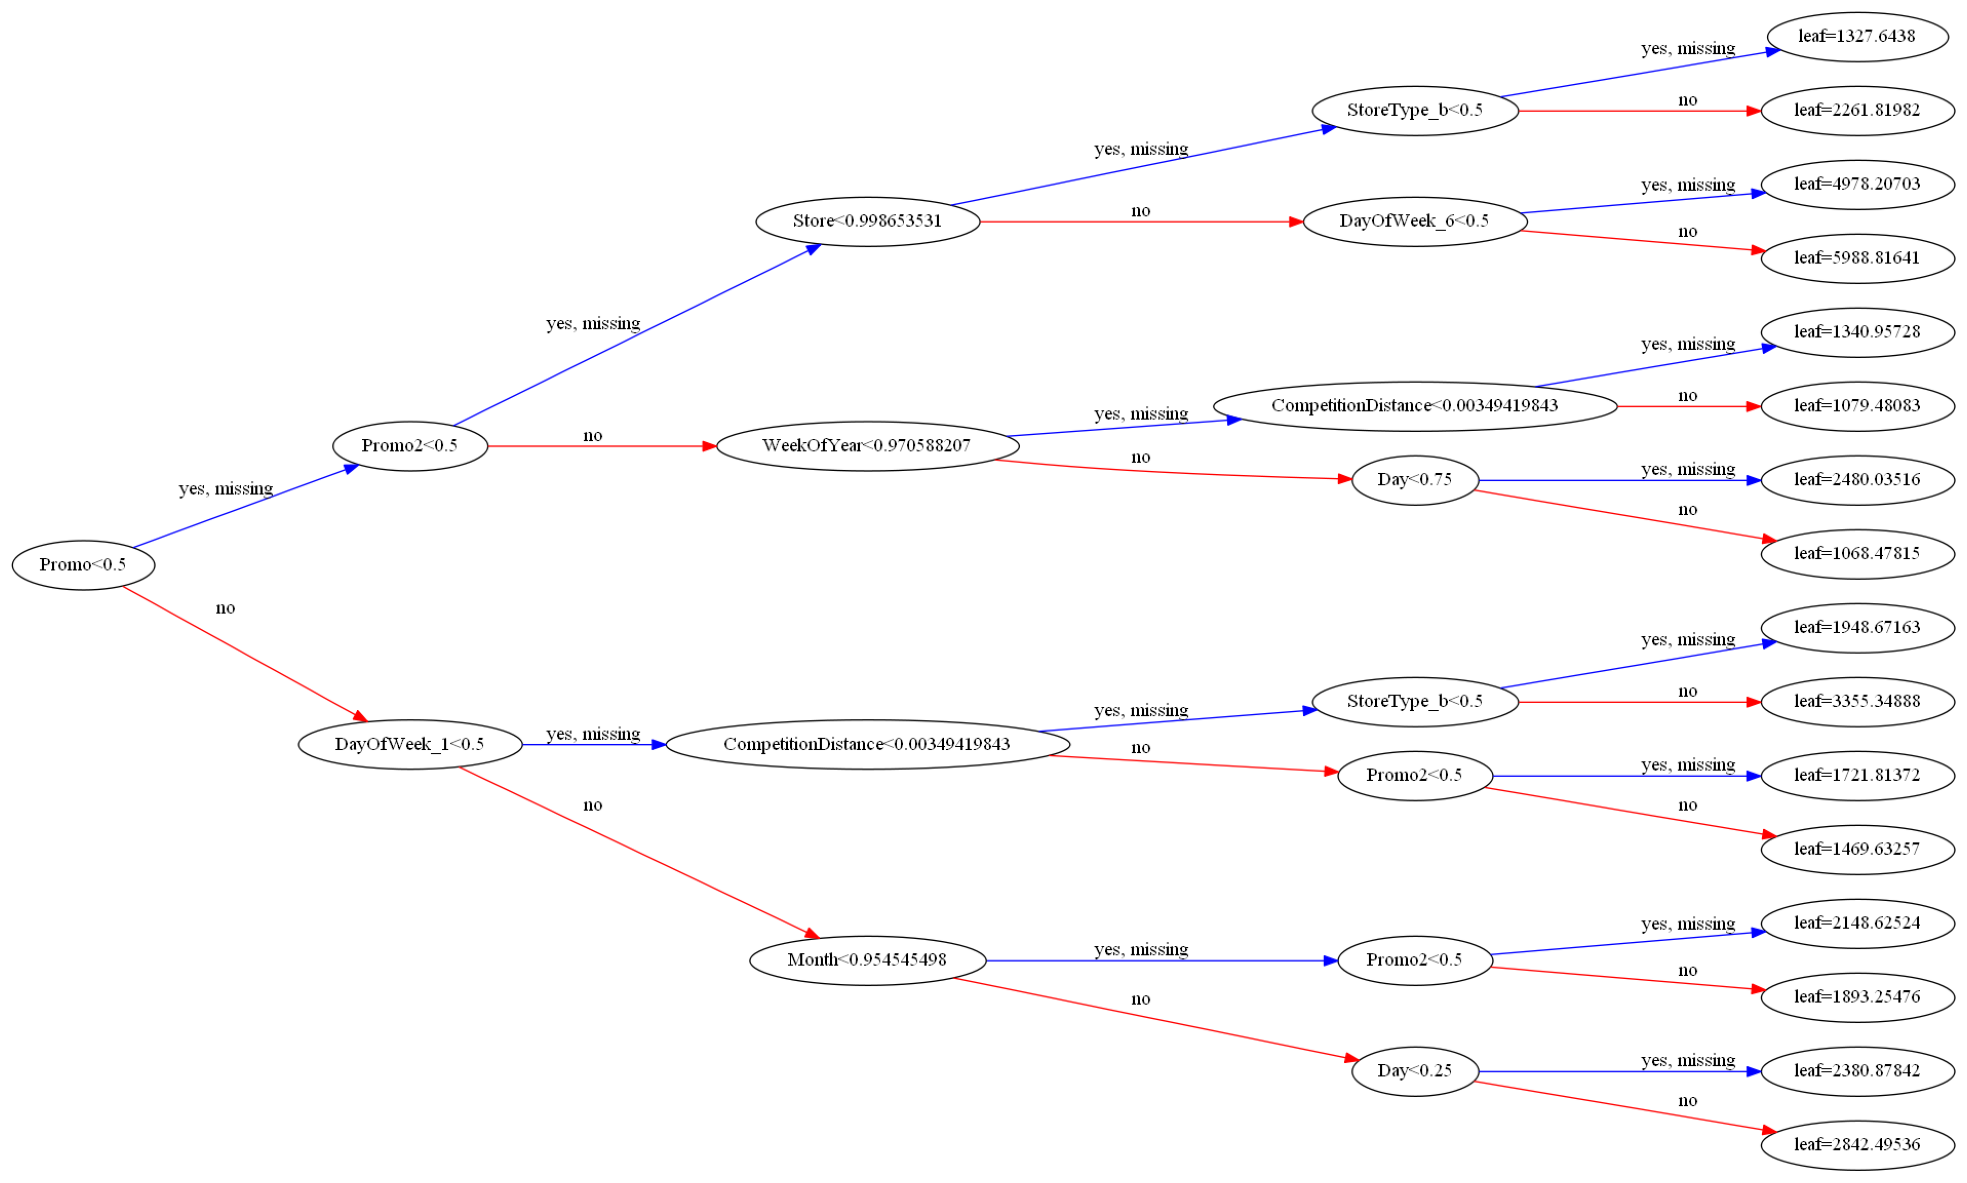

In [54]:
plot_tree(xgb_model, rankdir='LR', num_trees=1);

In [55]:
trees = xgb_model.get_booster().get_dump()

In [56]:
len(trees)

20

In [57]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00441719405] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.01602057] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.0134493671] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.002703059] yes=27,no=28,missing=27
				27:leaf=334

### Feature importance

Let us look at the feature importance score for each column in the input.

In [58]:
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [59]:
feature_importance_df.head(10)

,feature,importance
1,Promo,0.317473
24,StoreType_b,0.086472
12,DayOfWeek_1,0.082269
5,Promo2,0.063986
3,CompetitionDistance,0.045053
29,Assortment_c,0.040226
27,Assortment_a,0.038759
9,Month,0.038493
0,Store,0.038119
8,Day,0.033209


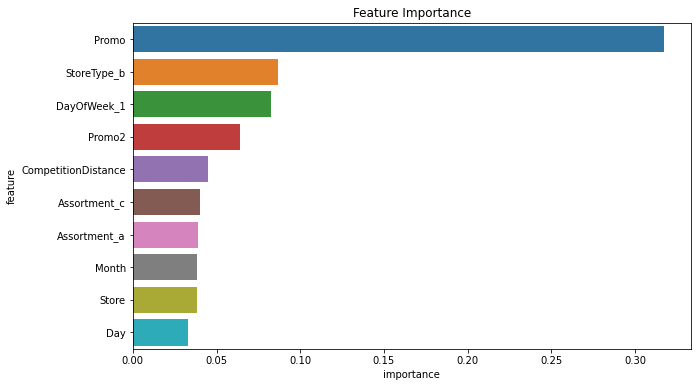

In [60]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Now, We'll use a validation strategy as K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

In [61]:
from sklearn.model_selection import KFold

In [62]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [63]:
kfold = KFold(n_splits=5)

In [64]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2352.216448531526, Validation RMSE: 2424.6228916973314
Train RMSE: 2406.709513789309, Validation RMSE: 2451.9646038059277
Train RMSE: 2365.7354745443067, Validation RMSE: 2336.984157073758
Train RMSE: 2366.4732092777763, Validation RMSE: 2460.8995475901697
Train RMSE: 2379.3752997474626, Validation RMSE: 2440.665320626728


In [65]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [66]:
preds = predict_avg(models, X)

In [67]:
preds

array([8021.374 , 7577.715 , 8747.863 , ..., 7615.0303, 7924.784 ,
       9600.297 ], dtype=float32)

In [68]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [72]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [73]:
test_params(n_estimators=10)

Train RMSE: 2359.8201212011245, Validation RMSE: 2352.91963350328


In [74]:
test_params(n_estimators=50)

Train RMSE: 1615.517413119821, Validation RMSE: 1613.1419480833797


In [75]:
test_params(n_estimators=100)

Train RMSE: 1190.1389155142026, Validation RMSE: 1192.146827002318


In [76]:
%%time
test_params(n_estimators=200)

Train RMSE: 943.9965508006356, Validation RMSE: 952.9395060775292
Wall time: 3min 13s


In [77]:
%%time
test_params(n_estimators=300)

Train RMSE: 851.7127152913272, Validation RMSE: 867.6061266005231
Wall time: 4min 56s


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [78]:
test_params(max_depth = 2)

Train RMSE: 2351.6258987425954, Validation RMSE: 2344.455994927655


In [79]:
test_params(max_depth = 5)

Train RMSE: 1413.6486611684334, Validation RMSE: 1407.1491755520478


In [80]:
test_params(max_depth = 10)

Train RMSE: 693.6318182486714, Validation RMSE: 782.2296402259599


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [81]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5044.895388570404, Validation RMSE: 5030.44893535651


In [82]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2168.9129231821726, Validation RMSE: 2161.659879487554


In [83]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1615.517413119821, Validation RMSE: 1613.1419480833797


In [85]:
test_params(n_estimators=50, learning_rate=0.5)

Train RMSE: 1307.2532299346403, Validation RMSE: 1305.5455391151638


In [86]:
test_params(n_estimators=50, learning_rate=0.7)

Train RMSE: 1156.4273291204836, Validation RMSE: 1159.0250778168129


In [87]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1150.8782856280739, Validation RMSE: 1166.095325081798


In [88]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [91]:
%%time
model.fit(X, targets)

Wall time: 21min 39s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [92]:
test_preds = model.predict(X_test)

Let's add the predictions into `submission_df`.

In [93]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [94]:
test_df.Open.isna().sum()

11

In [95]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [96]:
submission_df

,Id,Sales
0,1,4350.177246
1,2,7858.274902
2,3,9632.970703
3,4,7215.680176
4,5,7248.436035
...,...,...
41083,41084,2886.865967
41084,41085,7966.454102
41085,41086,5662.802246
41086,41087,21448.222656


In [97]:
submission_df.to_csv('submission.csv', index=None)